<a href="https://colab.research.google.com/github/feelzoo/MOV_Freeshipping_/blob/main/Copy_of_Shipping_cost_and_minimum_order_value_for_free_shipping_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Free Shipping Threshold & Shipping Rates for Ecommerce

In this project, I will perform data anlaysis that can help to make two business/logistical decisions for our ecommerce website as below: 


*   Determinig Free Shipping Threshold
*   Updating Shipping Rates

In [91]:
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from operator import itemgetter
from palettable.colorbrewer.diverging import *
from matplotlib import cm

In [92]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/NADRI/Shopify_Order_Product_Returns'
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [93]:
#@title
#for 'Shopify order data', split datetime into 'year' and 'month'
def year_month(data):
    data['year'] = ''
    data['month'] = ''
    for index, row in data.iterrows():
        try: 
            year = str(row['Created at']).split('-')[0]
            month = str(row['Created at']).split('-')[1]
        except: 
            year = '0'
            month = '0'
        data.at[index,'year'] = year
        data.at[index,'month'] = month

In [94]:
#@title
#for 'Shopify Order Data, create a histogram of average order value distribution
def AOV_distribution(df,tick,dis_type):
  fig = plt.figure(figsize = (15,10))
  sns.set_style('white')
  year_month(df)
  df_main = df[~df['Financial Status'].isna()]
  df_main_min = df_main[df_main.year == df_main.year.min()]
  df_main_max = df_main[df_main.year == df_main.year.max()]
  ax = sns.histplot(df_main['Total'],alpha = 1,label='2021',color = '#287094', binrange = (0,1000),bins=40,stat = dis_type)
  plt.legend(prop={'size':20})
  plt.title(f"Order Value Distribution {df_main_min['year'].min()}/{df_main_min['month'].min()}~{df_main_max['year'].min()}/{df_main_max['month'].max()}",fontsize = 30,fontweight='bold')
  plt.xlabel('Average Order Value per order',fontsize = 20)
  plt.ylabel('Number of Orders',fontsize = 20)
  plt.xticks(np.arange(0,1000,tick),fontsize = 13)
  plt.xlim(0,1000)
  plt.yticks(fontsize = 13)
  for p in ax.patches: 
    if dis_type == 'percent':
      value = f'{p.get_height():.0f}%'
    else:
      value = f'{p.get_height():.0f}'
    x= p.get_x() + p.get_width()/2
    y= p.get_height()
    ax.text(x,y,value,ha='center',va='bottom')
  return fig

In [95]:
#@title
#creating a column that put 'Shopify order value' into buckets 
def cat(x):
  bounds = list(range(50,200,25))+list(range(200,400,50))+list(range(400,1000,100))
  if x < bounds[0]:
    return f'< ${bounds[0]}'
  if x>=bounds[-1]:
    return f'{bounds[-1]}over'

  for i in range(len(bounds) - 1):
    if bounds[i] <= x < bounds[i+1]:
      return f'\\${bounds[i]}~${bounds[i+1]}'

In [96]:
#@title
#creating a column that put 'Shopify order value' into buckets 
def cat2(x):
  bounds = list(range(50,200,25))
  if x < bounds[0]:
    return f'<${bounds[0]}'
  if x>=bounds[-1]:
    return f'{bounds[-1]}over'
  for i in range(len(bounds)-1):
    if bounds[i] <= x < bounds[i+1]:
      return f'\\${bounds[i]}~${bounds[i+1]}'

In [97]:
#@title
#creating a column that put 'Shopify order value' into buckets 
def cat3(x):
  bounds = list(range(10,25,15)) +list(range(25,100,25))
  if x <bounds[0]:
    return f'<${bounds[0]}'
  if x >= bounds[-1]:
    return f'{bounds[-1]}over'
  for i in range(len(bounds)-1):
    if bounds[i] <= x < bounds[i+1]:
      return f'\\${bounds[i]}~${bounds[i+1]}'


# 1. Minimum Order Value for Free Shipping
Current plan: Free standard shipping for orders over $50

We can start by finding the number of orders by an order value to see how order values are distributed. This will help us understand our consumer behaviors around the free shipping threshold.  

## a. Dataset

In [98]:
#Shopify order data downloded into two csv files due to size.  
order1 = f'{root_path}/orders_export_2.csv'
order2 = f'{root_path}/orders_export_1 2.csv'

#Combining two csv files into one 
orders = pd.concat(map(pd.read_csv,[order1,order2]),ignore_index = True)
year_month(orders)

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/concat.py:304: DtypeWarning: Columns (45,71) have mixed types.Specify dtype option on import or set low_memory=False.
  sort=sort,


In [99]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058 entries, 0 to 24057
Data columns (total 79 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Name                         24058 non-null  object 
 1   Email                        23618 non-null  object 
 2   Financial Status             15046 non-null  object 
 3   Paid at                      14264 non-null  object 
 4   Fulfillment Status           15046 non-null  object 
 5   Fulfilled at                 14828 non-null  object 
 6   Accepts Marketing            15046 non-null  object 
 7   Currency                     15046 non-null  object 
 8   Subtotal                     15046 non-null  float64
 9   Shipping                     15046 non-null  float64
 10  Taxes                        15046 non-null  float64
 11  Total                        15046 non-null  float64
 12  Discount Code                5426 non-null   object 
 13  Discount Amount 

## b. Data Preprocessing

In [100]:
#deselecting unnecessary rows
orders_new = orders[~orders['Financial Status'].isna()]
#creating price_range columns
orders_new['price range'] = orders_new['Total'].apply(cat)
orders_new['price range2'] = orders_new['Total'].apply(cat2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [101]:
#Preprocessing for order value distribution graph: labels, colors
dollar = list(range(50,200,25))+list(range(200,400,50))+list(range(400,1100,100))
dollar2 = list(range(50,225,25))
dollar3 = list(range(10,25,15))+list(range(25,125,25))
colors = ['#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd']
labels1 = []
for i in range(len(dollar)):
  if i == 0:
    labels1.append(f'<${dollar[0]}')
  if 1 <= i < len(dollar):
    labels1.append(f'\\${dollar[i-1]}~${dollar[i]}')
  if i == len(dollar)-1:
    labels1.append(f'\\${dollar[-1]} over')
labels2 = []
for i in range(len(dollar2)):
  if i == 0:
    labels2.append(f'<${dollar2[i]}')
  if 1 <= i < len(dollar2):
    labels2.append(f"\\${dollar2[i-1]}~${dollar2[i]}")
  if i == len(dollar2)-1:
    labels2.append(f"\\${dollar2[i]}over")
labels3 = []
for i in range(len(dollar3)):
  if i == 0:
    labels3.append(f'<${dollar3[i]}')
  if 1 <= i < len(dollar3):
    labels3.append(f"\\${dollar3[i-1]}~${dollar3[i]}")
  if i == len(dollar3)-1:
    labels3.append(f"\\${dollar3[i]}over")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


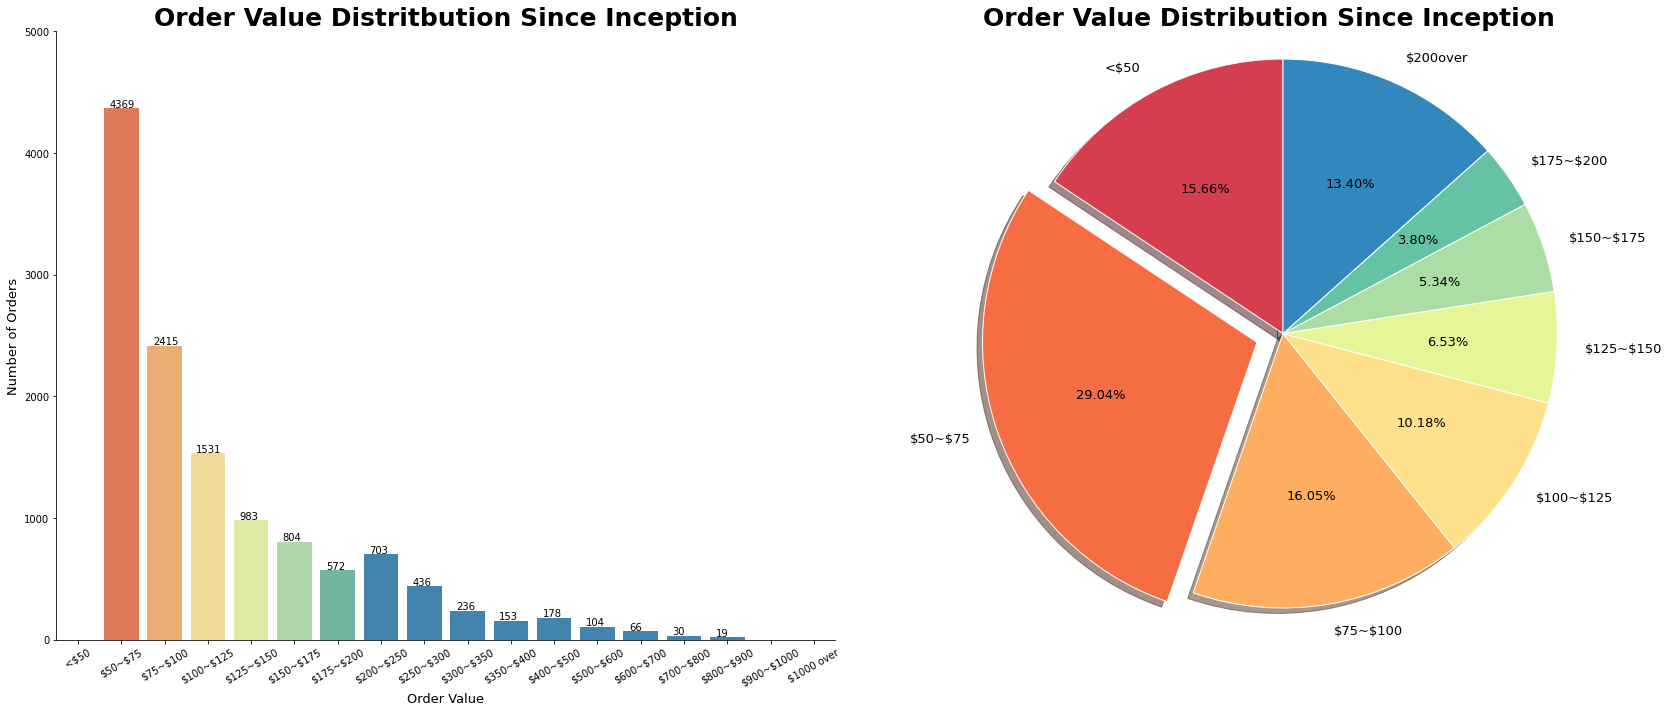

In [104]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
ax = sns.countplot(data=orders_new,x='price range',order=labels1,palette = colors)
plt.title('Order Value Distritbution Since Inception',fontsize=25,fontweight='bold')
plt.ylim([0,5000])
ax.set_xticklabels(labels1,rotation=30)
sns.despine(right=True,top = True)
plt.xlabel('Order Value',fontsize = 13)
plt.ylabel('Number of Orders',fontsize = 13)
for p in ax.patches: 
  number = f'{p.get_height():.0f}'
  x = p.get_x()+p.get_width()/6
  y = p.get_height() + 10
  plt.text(x,y,number)


plt.subplot(1,2,2)
count3 = [2356,4369,2415,1531,983,804,572,2016]
color_pie = ['#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd']
explode = [0,.1,0,0,0,0,0,0]
patches, texts, autotexts = plt.pie(count3,labels = labels2,wedgeprops = {'linewidth':1,'edgecolor':'white'}, textprops = {'size': 13}, shadow=True,autopct = '%.2f%%',colors = color_pie,explode=explode,startangle=90)
plt.setp(autotexts,color = 'black',size='13')
plt.title('Order Value Distribution Since Inception',fontsize=25,fontweight='bold')
plt.axis('equal')
plt.tight_layout()


## **Insights**

### 29.04% of the orders fall into the \$50~\$75 bucket.

There are two hypotheses on the dominance of the \$50~\$75 bucket
1. Current Free Shipping Threshold is \$50 - Consumers get peace of mind with free shipping and \$50~\$75 is the cheapest bucket to achieve that. 

2. Half of our items are priced less than \$75. As can be seen in the below item price distribution graphs, 53.78% of our items are priced less than \$75. 


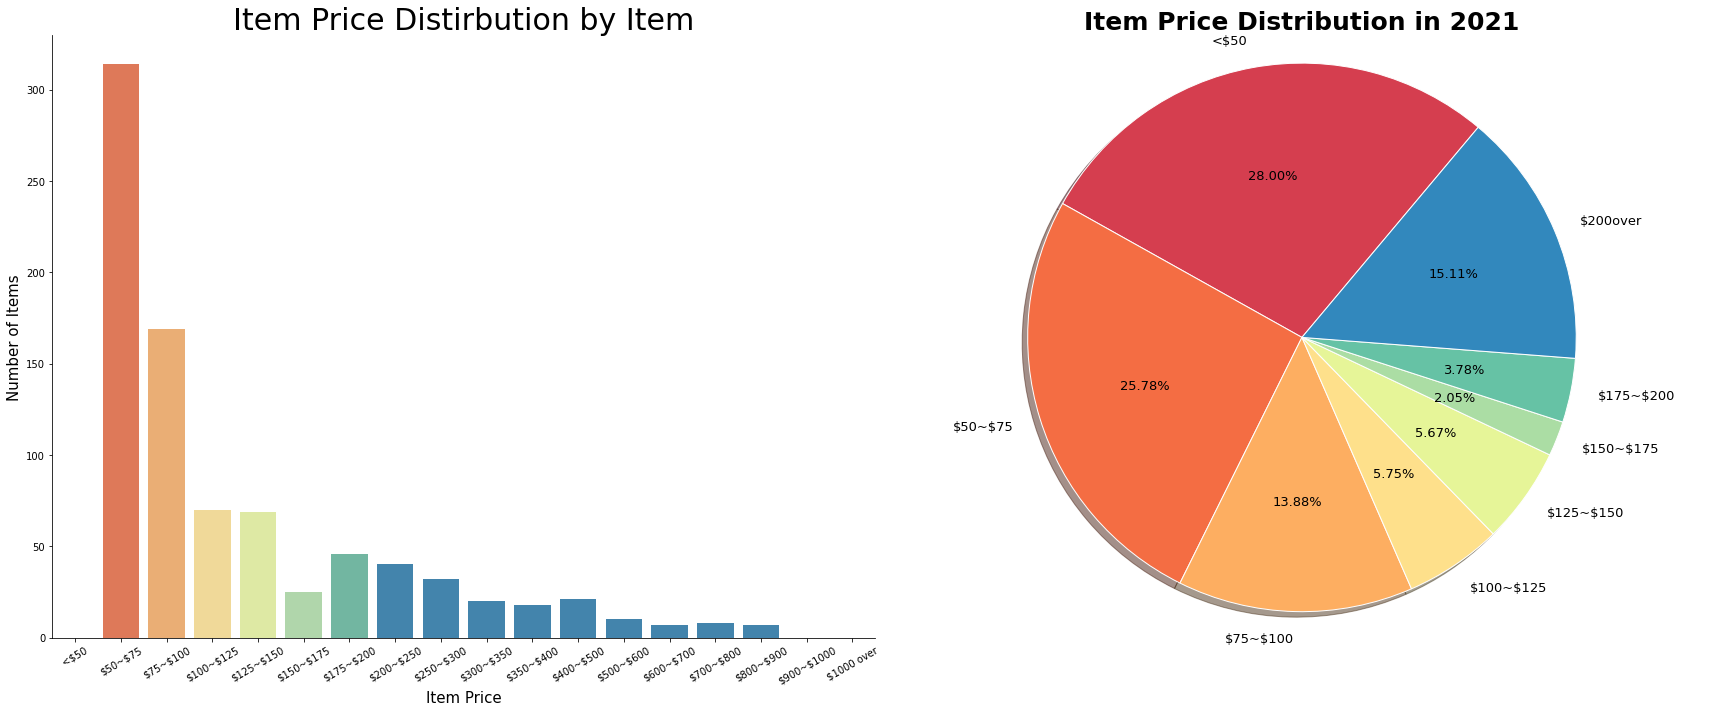

In [143]:
plt.figure(figsize = (24,10))
plt.subplot(1,2,1)
ax = sns.countplot(data = product2, x= 'price range',order = labels1,palette = ['#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd'])
ax.set_xticklabels(labels1,rotation=30,color='black')
plt.title('Item Price Distirbution by Item',fontsize = 30)
plt.tight_layout()
plt.xlabel('Item Price',fontsize=15)
plt.ylabel('Number of Items',fontsize=15)
sns.despine(top = True, right = True)


plt.subplot(1,2,2)
count_item = [341,314,169,70,69,25,46,184]
color_pie = ['#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd']
colors.reverse()
patches, texts, autotexts = plt.pie(count_item,labels = labels2,wedgeprops={'linewidth': 1, 'edgecolor': 'white'},shadow=True,autopct = '%.2f%%',colors = color_pie,startangle=50,textprops={'size': 13})
plt.setp(autotexts,color = 'black',size='13')
plt.title('Item Price Distribution in 2021',fontsize=25,fontweight='bold')
plt.axis('equal')
plt.tight_layout()


#**Recommendations** 

Increasing our free shipping threshold from \$50 to \$75 is highly recommended. Consumers love free shipping and there are many items offered between \$0 and \$75 which will give consumers plenty of options to reach an order value of \$75. I expect that some of the \$50~\$75 bucket customers will definitely spill over to the next two buckets (\$75-\$100 and \$100-\$125) which will lead to a higher average order value (AOV) due to a higher threshold. There might be more cart abandonments during the spill over process. However, given that most of our competitors are embracing $75 threshold and consumers are more immune to higher fees due to the pandemic, the benefits will outweigh the disadvantage such as cart abandonment. 

#**New Shipping Rates**


In [ ]:
combined4 = orders.groupby(['Name','Shipping Method','year'])['Lineitem quantity','Lineitem price','Shipping'].sum().reset_index()

In [106]:
y_2017 = combined4[combined4['year'] == '2017']
y_2018 = combined4[combined4['year'] == '2018']
y_2019 = combined4[combined4['year'] == '2019']
y_2020 = combined4[combined4['year'] == '2020']
y_2021 = combined4[combined4['year'] == '2021']

In [107]:
y_2017 = y_2017[y_2017['Shipping Method'] != 'In store shipping']
y_2018 = y_2018[y_2018['Shipping Method'] != 'In store shipping']

#2017 Shipping Method
next_2017 = y_2017[y_2017['Shipping Method'].isin(['Next Day Air - UPS'])]
second_2017 = y_2017[y_2017['Shipping Method'].isin(['2nd Day Air - UPS','Free USPS Priority Mail'])]
ground_2017 = y_2017[y_2017['Shipping Method'].isin(['Free Ground Shipping - UPS','Ground - UPS'])]
other_2017 = y_2017[y_2017['Shipping Method'].isin(['In store shipping','Express Worldwide - DHL','Custom'])]

#2018 Shipping Method
next_2018 = y_2018[y_2018['Shipping Method'].isin(['Next Day Air - UPS'])]
second_2018 = y_2018[y_2018['Shipping Method'].isin(['2nd Day Air - UPS','Free USPS Priority Mail','2nd Day - UPS','2nd Day UPS'])]
ground_2018 = y_2018[y_2018['Shipping Method'].isin(['Free Ground Shipping - UPS','Ground Shipping - UPS','UPS GROUND SHIPPING','UPS GROUND SHIPPING FEE','UPS Ground','UPS Ground Delivery Service','UPS Ground Shipping','UPS Ground Shipping Fee','UPS STANDARD SHIPPING FEE','UPS Standard Ground','UPS Ground Service','UPS GROUND SERVICE','Standard UPS Ground Shipping','STANDARD UPS GROUND SERVICE','STANDARD UPS GROUND SERVICE','SHIPPING UPS GROUND','UPS SHIPPING FEE','UPS Shipping Fee','Ground - UPS'])]
other_2018 = y_2018[y_2018['Shipping Method'].isin(['In store shipping','Express Worldwide - DHL','Custom','DHL Express Worldwide Shipping Fee'])]

#2019 Shpping Method
next_2019 = y_2019[y_2019['Shipping Method'].isin(['Next Day Air - UPS','Free Overnight UPS','Free Next Day UPS','USPS PRIORITY EXPRESS SERVICE'])]
second_2019 = y_2019[y_2019['Shipping Method'].isin(['2nd Day UPS','2nd Day - UPS','2nd Day Air - UPS','Free USPS Priority Mail','2nd Day - UPS','2nd Day UPS','Free 2nd Day UPS','2nd Day UPS - Holiday Promotion'])]
ground_2019 = y_2019[y_2019['Shipping Method'].isin(['Free Ground Shipping - UPS','Ground Shipping - UPS','USPS Free Shipping','UPS GROUND SHIPPING','UPS GROUND SHIPPING FEE','UPS Ground','UPS Ground Delivery Service','UPS Ground Shipping','UPS Ground Shipping Fee','UPS STANDARD SHIPPING FEE','UPS Standard Ground','UPS Ground Service','UPS GROUND SERVICE','Standard UPS Ground Shipping','STANDARD UPS GROUND SERVICE','STANDARD UPS GROUND SERVICE','SHIPPING UPS GROUND','UPS SHIPPING FEE','UPS Shipping Fee','UPS Ground Shipping','Free Ground Shipping','UPS GROUND SHIPPING','Free Ground Shipping','UPS Ground Shipping Fee','UPS Ground Shipping','Free shipping'])]
other_2019 = y_2019[y_2019['Shipping Method'].isin(['In store shipping','Express Worldwide - DHL','Custom','DHL Express Worldwide Shipping Fee','DHL WORLDWIDE EXPRESS SHIPMENT','DHL WORLDWIDE EXPRESS SHIPPING FEE','DHL - EXPRESS WORLDWIDE SHIPPING FEE','DHL Worldwide Express','Worldwide Express - DHL','Worldwide Express - DHL','DHL WorldWide Express Shipping Fee'])]


#2020 Shipping Method
next_2020 = y_2020[y_2020['Shipping Method'].isin(['Next Day Air - UPS','Free Overnight UPS','USPS PRIORITY EXPRESS SERVICE','Next Day Air','Free Next Day Air - UPS'])]
second_2020 = y_2020[y_2020['Shipping Method'].isin(['2nd Day UPS','2nd Day - UPS','2nd Day Air - UPS','Free USPS Priority Mail','2nd Day - UPS','2nd Day UPS','Free 2nd Day UPS','2nd Day UPS - Holiday Promotion','Free 2nd Day Air - UPS','2nd Day Air - UPS','Free 2nd day - UPS','2nd Day UPS','Free 2nd Day UPS'])]
ground_2020 = y_2020[y_2020['Shipping Method'].isin(['Free Ground Shipping - UPS','Ground Shipping - UPS','USPS Free Shipping','Flat Rate Shipping  - USPS','USPS - Flat Rate Shipping','UPS GROUND SHIPPING','UPS GROUND SHIPPING FEE','UPS Ground','UPS Ground Delivery Service','UPS Ground Shipping','UPS Ground Shipping Fee','UPS STANDARD SHIPPING FEE','UPS Standard Ground','UPS Ground Service','UPS GROUND SERVICE','Standard UPS Ground Shipping','STANDARD UPS GROUND SERVICE','STANDARD UPS GROUND SERVICE','SHIPPING UPS GROUND','UPS SHIPPING FEE','UPS Shipping Fee','UPS Ground Shipping','Free Ground Shipping','Free shipping','UPS Ground Shipping Fee'])]
other_2020 = y_2020[y_2020['Shipping Method'].isin(['In store shipping','Express Worldwide - DHL','Custom','DHL Express Worldwide Shipping Fee','DHL WORLDWIDE EXPRESS SHIPMENT','DHL WORLDWIDE EXPRESS SHIPPING FE','DHL - EXPRESS WORLDWIDE SHIPPING FEE','DHL Worldwide Express','Worldwide'])]

#2021 Shipping Method
next_2021 = y_2021[y_2021['Shipping Method'].isin(['Next Day Air - UPS','Free Overnight UPS','USPS PRIORITY EXPRESS SERVICE','Next Day Air','Free Next Day Air - UPS'])]
second_2021 = y_2021[y_2021['Shipping Method'].isin(['2nd Day UPS','2nd Day - UPS','2nd Day Air - UPS','Free USPS Priority Mail','2nd Day - UPS','2nd Day UPS','Free 2nd Day UPS','2nd Day UPS - Holiday Promotion','Free 2nd Day Air - UPS','2nd Day Air - UPS','Free 2nd day - UPS','2nd Day UPS','Free 2nd Day UPS','2nd Day Air - FedEx','Free 2nd Day Air - FedEx','Free 2nd Day Air - UPS'])]
ground_2021 = y_2021[y_2021['Shipping Method'].isin(['Free Ground Shipping - UPS','Ground Shipping - UPS','USPS Free Shipping','Flat Rate Shipping  - USPS','USPS - Flat Rate Shipping','UPS GROUND SHIPPING','UPS GROUND SHIPPING FEE','UPS Ground','UPS Ground Delivery Service','UPS Ground Shipping','UPS Ground Shipping Fee','UPS STANDARD SHIPPING FEE','UPS Standard Ground','UPS Ground Service','UPS GROUND SERVICE','Standard UPS Ground Shipping','STANDARD UPS GROUND SERVICE','STANDARD UPS GROUND SERVICE','SHIPPING UPS GROUND','UPS SHIPPING FEE','UPS Shipping Fee','UPS Ground Shipping','Free Ground Shipping','Free shipping','UPS Ground Shipping Fee','Flat Rate Shipping  - USPS','Free UPS Ground shipping','Free Ground Shipping -UPS'])]
other_2021 = y_2021[y_2021['Shipping Method'].isin(['In store shipping','Express Worldwide - DHL','Custom','DHL Express Worldwide Shipping Fee','DHL WORLDWIDE EXPRESS SHIPMENT','DHL WORLDWIDE EXPRESS SHIPPING FE','DHL - EXPRESS WORLDWIDE SHIPPING FEE','DHL Worldwide Express','Worldwide','Express Worldwide - DHL (0.7 lb)'])]


In [108]:
shipping_price = orders[['year','Shipping Method','Shipping']]

In [109]:
method = ['Ground','2nd Day Air','Next Day Air','Other']

In [110]:
shipping_2017 = pd.DataFrame(data = [[len(ground_2017),len(second_2017),len(next_2017),len(other_2017)]],columns=method)
shipping_2018 = pd.DataFrame(data = [[len(ground_2018),len(second_2018),len(next_2018),len(other_2018)]],columns=method)
shipping_2019 = pd.DataFrame(data = [[len(ground_2019),len(second_2019),len(next_2019),len(other_2019)]],columns=method)
shipping_2020 = pd.DataFrame(data = [[len(ground_2020),len(second_2020),len(next_2020),len(other_2020)]],columns=method)
shipping_2021 = pd.DataFrame(data = [[len(ground_2021),len(second_2021),len(next_2021),len(other_2021)]],columns=method)

In [111]:
shipping_2017 = list([len(ground_2017),len(second_2017),len(next_2017),len(other_2017)])
shipping_2018 = list([len(ground_2018),len(second_2018),len(next_2018),len(other_2018)])
shipping_2019 = list([len(ground_2019),len(second_2019),len(next_2019),len(other_2019)])
shipping_2020 = list([len(ground_2020),len(second_2020),len(next_2020),len(other_2020)])
shipping_2021 = list([len(ground_2021),len(second_2021),len(next_2021),len(other_2021)])

In [112]:
shipping_stats = [shipping_2017,shipping_2018,shipping_2019,shipping_2020,shipping_2021]

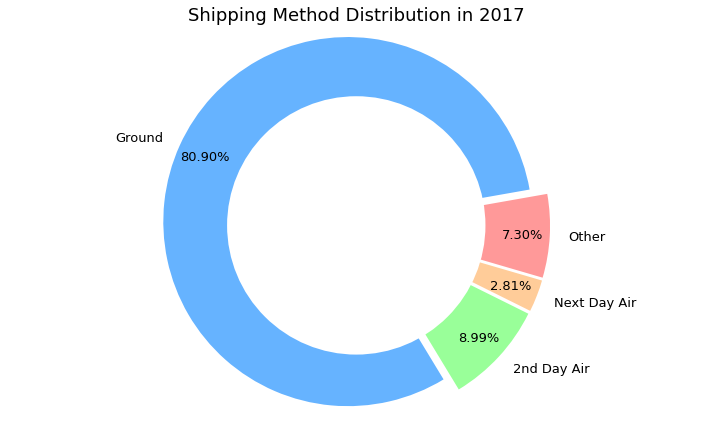

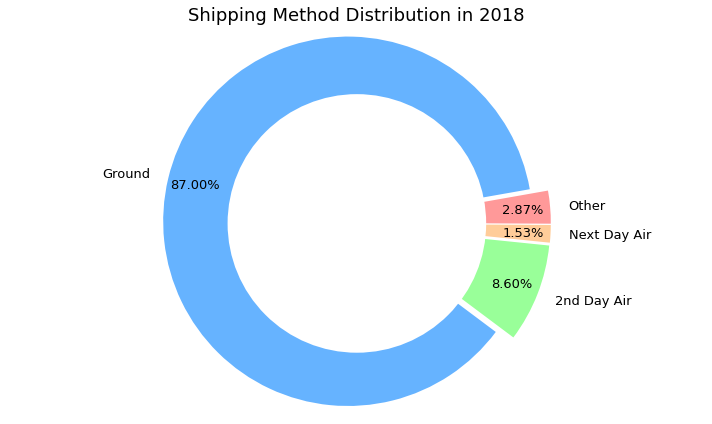

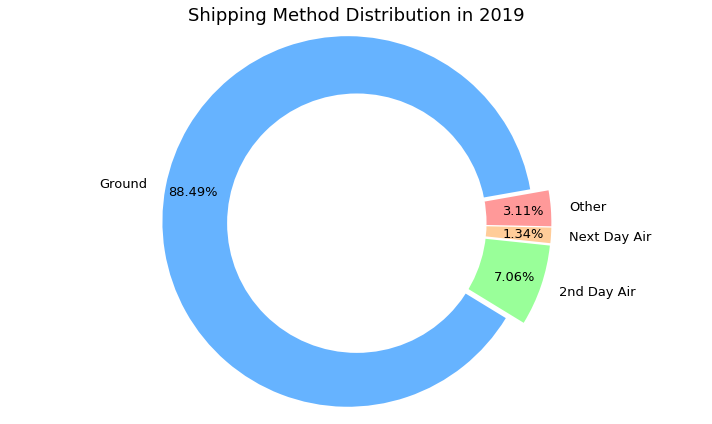

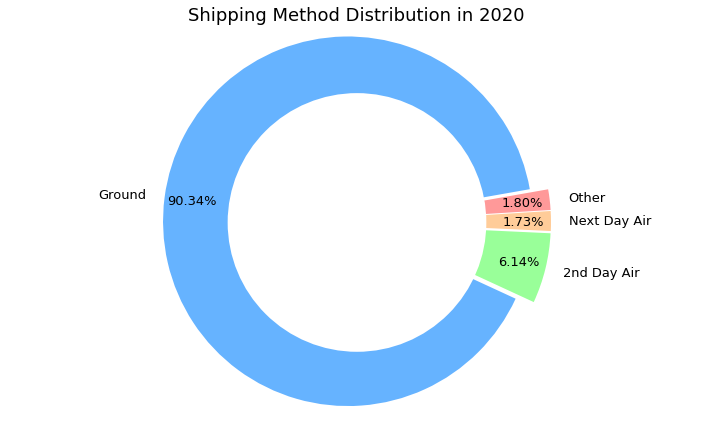

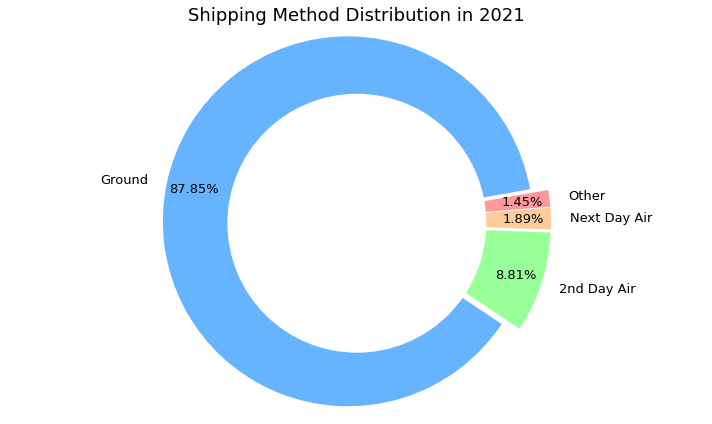

In [113]:
for i in range(len(shipping_stats)):
    plt.figure(figsize=(10,6))
    colors = ['#66b3ff','#99ff99','#ffcc99','#ff9999']
    explode = (.05,.05,.05,.05)
    plt.pie(shipping_stats[i],labels = method,colors=colors, autopct = '%.2f%%',textprops = {'fontsize': 13},explode=explode,startangle=10,pctdistance=.85)
    plt.title('Shipping Method Distribution in {0}'.format(2017+i),fontsize=18)
    center_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(center_circle)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('Shipping Method in {0}.png'.format(2017+i))
    plt.show()
    

In [114]:
product = pd.read_csv(f'{root_path}/products.csv')

In [115]:
product1 = product.dropna(subset=['Variant SKU'])

In [116]:
product1['price range'] = product1['Variant Price'].apply(cat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [117]:
product2 = product.dropna(subset = ['Title'])
product3 = product2[product2['Status'].str.contains('active')]

In [118]:
product2['price range'] = product2['Variant Price'].apply(cat)
product2['price range2'] = product2['Variant Price'].apply(cat2)
product2['price range3'] = product2['Variant Price'].apply(cat3)
product3['price range'] = product3['Variant Price'].apply(cat)
product3['price range2'] = product3['Variant Price'].apply(cat2)
product3['price range3'] = product3['Variant Price'].apply(cat3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [119]:
p10 = product3[product3['price range3'] == '< $10'][['Variant SKU','Title','Variant Price','price range3']]
p1025 = product3[product3['price range3'] == '\$10~$25'][['Variant SKU','Title','Variant Price','price range3']]
p2550 = product3[product3['price range3'] == '\$25~$50'][['Variant SKU','Title','Variant Price','price range3']]
p10.to_excel(f"{root_path}/p10.xlsx")
p1025.to_excel(f"{root_path}/p1025.xlsx")
p2550.to_excel(f"{root_path}/p2550.xlsx")

In [120]:
product3[product3['price range3'] == '\$25~$50']['Variant Price'].mean()

39.341911764705884

In [121]:
product1.columns

Index(['Handle', 'Title', 'Body (HTML)', 'Vendor', 'Standard Product Type',
       'Custom Product Type', 'Tags', 'Published', 'Option1 Name',
       'Option1 Value', 'Option2 Name', 'Option2 Value', 'Option3 Name',
       'Option3 Value', 'Variant SKU', 'Variant Grams',
       'Variant Inventory Tracker', 'Variant Inventory Qty',
       'Variant Inventory Policy', 'Variant Fulfillment Service',
       'Variant Price', 'Variant Compare At Price',
       'Variant Requires Shipping', 'Variant Taxable', 'Variant Barcode',
       'Image Src', 'Image Position', 'Image Alt Text', 'Gift Card',
       'SEO Title', 'SEO Description',
       'Google Shopping / Google Product Category', 'Google Shopping / Gender',
       'Google Shopping / Age Group', 'Google Shopping / MPN',
       'Google Shopping / AdWords Grouping',
       'Google Shopping / AdWords Labels', 'Google Shopping / Condition',
       'Google Shopping / Custom Product', 'Google Shopping / Custom Label 0',
       'Google Shopping / 

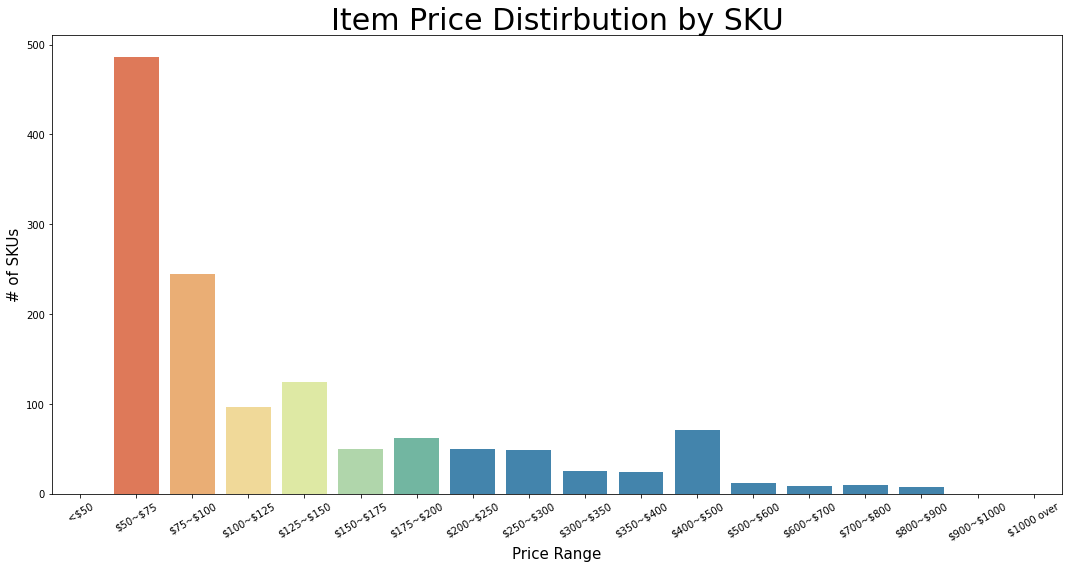

In [124]:
plt.figure(figsize = (15,8))
ax = plt.subplot()
sns.countplot(data = product1, x= 'price range',order = labels1, palette = ['#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd'])
ax.set_xticklabels(labels1,rotation=30,color='black')
plt.xlabel('Price Range',fontsize= 15)
plt.ylabel('# of SKUs',fontsize = 15)
plt.title('Item Price Distirbution by SKU',fontsize = 30)
plt.tight_layout()
plt.savefig('Item Price Distribution by SKU.png')

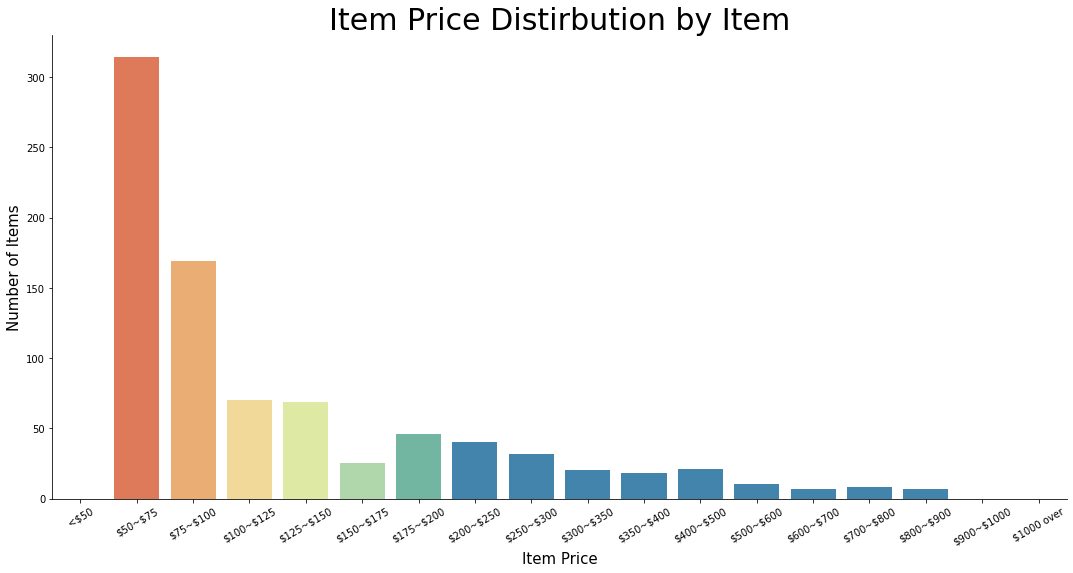

In [127]:
product3['price range3'].value_counts()

75over      301
\$50~$75    171
\$25~$50    136
\$10~$25      3
<$10          1
Name: price range3, dtype: int64

In [128]:
product4 = product3[product3['price range3'] != '\$100 over']

NameError: ignored

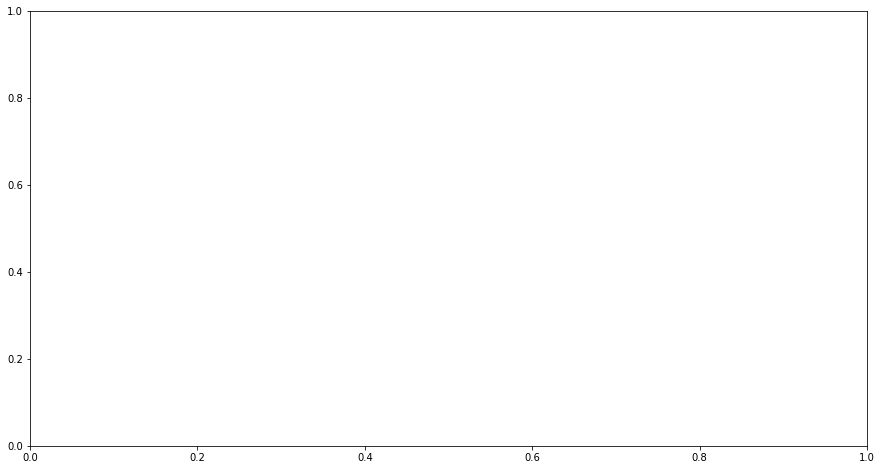

In [129]:
plt.figure(figsize = (15,8))
ax = plt.subplot()
sns.countplot(data = product4, x= 'price range3',order = labels4,color='black')
ax.set_xticklabels(labels4,rotation=30,color='black')
plt.title('Item Price Distirbution by Item',fontsize = 30)
plt.tight_layout()
plt.xlabel('Item Price',fontsize=15)
plt.ylabel('Number of Items',fontsize=15)
sns.despine(top = True, right = True)
plt.savefig(f'{root_path}/Item Price Distribution by Item_more_details.png')

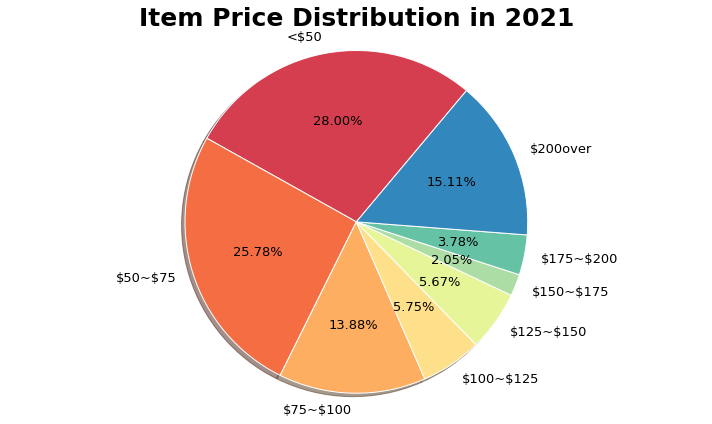

In [134]:
count_item = [341,314,169,70,69,25,46,184]
color_pie = ['#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd']
colors.reverse()
plt.figure(figsize=(10,6))
ax = plt.subplot()
patches, texts, autotexts = plt.pie(count_item,labels = labels2,wedgeprops={'linewidth': 1, 'edgecolor': 'white'},shadow=True,autopct = '%.2f%%',colors = color_pie,startangle=50,textprops={'size': 13})
plt.setp(autotexts,color = 'black',size='13')
plt.title('Item Price Distribution in 2021',fontsize=25,fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.savefig('Item Price Distribution Pie Chart 2021')

In [132]:
sku = orders[['Lineitem sku','Lineitem name','Lineitem price','Lineitem quantity']]

In [133]:
sku['Lineitem sku'].fillna('No SKU',inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
free = y_2021[y_2021['Shipping Method'] == 'USPS Free Shipping']

In [ ]:
moon = orders[orders['year'] == '2019']

In [ ]:
moon['Shipping Method'].value_counts()

In [ ]:
moon2 = moon.dropna(subset=['Shipping Method'])
moon2['price range'] = moon2['Total'].apply(cat2)
lowest2 = moon2[moon2['price range'] == '< $50']

In [ ]:
pd.set_option('display.min_rows',20)

In [ ]:
lowest2['Shipping Method'].value_counts()

In [ ]:
joo = orders[orders['year'] == '2018']

In [ ]:
pj = orders[orders['year'] == '2017']

In [ ]:
pj['Shipping'].value_counts()

In [ ]:
joo2 = joo.dropna(subset = ['Shipping Method'])

In [ ]:
joo2['price range'] = joo2.Total.apply(cat2)